In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install mpl_finance
!pip install pybithumb

     |████████████████████████████████| 61kB 5.0MB/s 
     |████████████████████████████████| 235kB 13.6MB/s 


In [3]:
# import pybithumb
import numpy as np
import pandas as pd
from datetime import datetime
import os, sys
# from scipy import stats
# from asq.initiators import query
import time
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MaxAbsScaler
import mpl_finance as mf
import time
from scipy.ndimage.filters import gaussian_filter1d
import pybithumb

gdrive_path = '/content/gdrive/My Drive/Colab Notebooks/'
current_path = gdrive_path + 'Project_Stock/'
sys.path.append(current_path)
from finta import TA

In [ ]:
def profitage(Coin, long_signal_value, short_signal_value, long_period, short_period, wait_tick=3, Date='2019-09-25', excel=0, get_fig=0):


    global length
    dir = gdrive_path + 'ohlcv/'

    if not Coin.endswith('.xlsx'):
        df = pybithumb.get_candlestick(Coin, 'KRW', '1m')
        # df_short = pybithumb.get_candlestick(Coin, 'KRW', '1m')
        # df_short2 = pybithumb.get_ohlcv(Coin, 'KRW', 'minute5')
    else:
        df = pd.read_excel(dir + '%s' % Coin, index_col=0)
    # df = pd.read_excel('./BestSet/Test_ohlc/%s' % Coin, index_col=0)

    chart_height = (df['high'].max() - df['low'].min())

    df['MA_SHORT'] = df['close'].rolling(30).mean()
    df['MA_LONG'] = df['close'].rolling(120).mean()
    df['MA_TREND'] = np.where(df['MA_LONG'].shift(1) <= df['MA_LONG'], 'UP', 'DOWN')

    
    df['MA_LONG_FOR_SLOPE'] = (df['MA_LONG'] - df['low'].min()) / chart_height
    df['MA_LONG_SLOPE'] = np.NaN
    slope_period = 20
    for s in range(slope_period - 1, len(df)):
        df['MA_LONG_SLOPE'].iloc[s] = stats.linregress([i for i in range(slope_period)], df['MA_LONG_FOR_SLOPE'][s + 1 - slope_period:s + 1])[0]
    df['MA_LONG_SLOPE'] *= 1e3


    df['TRIX'] = TA.TRIX(df, period=10)
    df['TRIX'] = np.where(np.isnan(df['TRIX']), 0, df['TRIX'])
    df['TRIX_TREND'] = np.where(df['TRIX'].shift(1) <= df['TRIX'], 'UP', 'DOWN')

    # df['RSI'] = TA.RSI(df, period=60)
    # for i in range(60, 0, -1):
    #     df['RSI'].iloc[i - 1] = df['RSI'].iloc[i]
    df['FISHER_LONG'] = TA.FISH(df, period=long_period)
    fisher_height = df['FISHER_LONG'].max() - df['FISHER_LONG'].min()

    df['SCALED_FISHER'] = (df['FISHER_LONG'] - df['FISHER_LONG'].min()) / fisher_height
    df['FISHER_TRIX'] = TA.TRIX(df, period=11, column='SCALED_FISHER')
    # print(df['FISHER_TRIX'].head(20))
    # quit()
    df['FISHER_TRIX_TREND'] = np.where(df['FISHER_TRIX'].shift(1) <= df['FISHER_TRIX'], 'UP', 'DOWN')

    # df['TRIX_LATER'] = TA.TRIX(df, period=20)
    # df['TRIX_LATER'] = np.where(np.isnan(df['TRIX_LATER']), 0, df['TRIX_LATER'])

    df['FISHER_TREND'] = np.where(df['FISHER_LONG'] > df['FISHER_LONG'].shift(1), 'UP', 'DOWN')
    df['FIHSER_IP'] = np.where(df['FISHER_TREND'].shift(1) != df['FISHER_TREND'], 1, 0)
    # df['Fisher_long_gaussian'] = df.FISHER_LONG.rolling(60).mean()
    # df['Fisher_short_gaussian'] = df.FISHER_SHORT.rolling(60).mean()

    #           REALTIME CURVE          #
    smoothed_curve = [np.nan] * len(df)
    smoothed_curve_short = [np.nan] * len(df)
    close_list = [np.nan] * len(df)
    period = 5
    sigma = 5
    df['TRIX_FOR_GAUSSIAN'] = TA.TRIX(df, period=16)
    for i in range(period, len(df)):
        y = df['FISHER_LONG'].values[i + 1 - period:i + 1]
        y_short = df['TRIX_FOR_GAUSSIAN'].values[i + 1 - period:i + 1]
        y_smooth = gaussian_filter1d(y, sigma=sigma)
        y_smooth_short = gaussian_filter1d(y_short, sigma=sigma)
        smoothed_curve[i] = y_smooth[-1]
        smoothed_curve_short[i] = y_smooth_short[-1]

        # close = df.close.values[i + 1 - period:i + 1]
        # close = gaussian_filter1d(close, sigma=sigma, mode='reflect')
        # close_list[i] = close[-1]

    df['FISHER_GAUSSIAN'] = smoothed_curve
    df['FISHER_GAUSSIAN_TREND'] = np.where(df['FISHER_GAUSSIAN'].shift(1) <= df['FISHER_GAUSSIAN'], 'UP', 'DOWN')
    #
    df['TRIX_GAUSSIAN'] = smoothed_curve_short
    df['TRIX_GAUSSIAN'] = np.where(np.isnan(df['TRIX_GAUSSIAN']), 0, df['TRIX_GAUSSIAN'])
    df['TRIX_GAUSSIAN_TREND'] = np.where(df['TRIX_GAUSSIAN'].shift(1) <= df['TRIX_GAUSSIAN'], 'UP', 'DOWN')

    trix_entry_previous_gap = 0.0005
    trix_entry_vertical_gap = 0.06
    trix_horizontal_ticks = 5
    trix_exit_vertical_gap = 0.17
    FISHER_trix_exit_vertical_gap = 0.8
    trix_exit_gap = -0.01
    trix_exit_previous_gap = -0.002
    upper_line = 10
    lower_line = -15

    # long_signal_value = 0
    # short_signal_value = 2.0
    long_ic_signal_value = -2.0
    detect_close_value = long_signal_value
    high_check_value = 2
    high_check_value_exit = 1.7
    high_check_value2 = 0
    high_check_value2_exit = 0
    exit_short_signal_value = -1.0

    #           SMMA DC          #
    smma_period = 200
    smma_slope_range = -0.2
    smma_accept_range = -0.08
    dc_accept_range = 0.05

    sell_price_gap = 0.25
    dc_lowprice_accept_gap_range = 0.03
    dc_entry_gap = -0.02
    # dc_exit_gap = -0.02
    dc_exit_gap = -0.035

    dc_horizontal_gap = 30
    dc_low_entry_low_accept_gap_range = 0.05
    dc_descend_accept_gap_range = -0.03

    df['SMMA'] = TA.SMMA(df, period=smma_period)

    dc_period_entry = 20
    df['DC_LOW_ENTRY'] = TA.DO(df, lower_period=dc_period_entry, upper_period=dc_period_entry)['LOWER']
    df['SMMA_DC_GAP'] = (df['DC_LOW_ENTRY'] - df['SMMA']) / chart_height

    #           DC CLOSE           #
    dc_period = 100
    # dc_period = 120
    dc_slow_period = 110
    df['DC_LOW'] = TA.DO(df, lower_period=dc_period, upper_period=dc_period)['LOWER']
    df['DC_LOW_SLOW'] = TA.DO(df, lower_period=dc_slow_period, upper_period=dc_slow_period)['LOWER']
    df['LOW_DC_GAP'] = (df['low'] - df['DC_LOW']) / chart_height
    df['LOW_SLOW_DC_GAP'] = (df['low'] - df['DC_LOW_SLOW']) / chart_height
    df['DC_TREND'] = np.where(df['DC_LOW'].shift(1) <= df['DC_LOW'], 'UP', 'DOWN')
    df['DC_SLOW_TREND'] = np.where(df['DC_LOW_SLOW'].shift(1) <= df['DC_LOW_SLOW'], 'UP', 'DOWN')
    for i in range(1, len(df)):
        # if np.isnan(df['DC_LOW'].iloc[i - 1]):
        #     df['DC_TREND'].iloc[i] = 'UP'
        if df['DC_LOW'].iloc[i] == df['DC_LOW'].iloc[i - 1]:
            df['DC_TREND'].iloc[i] = df['DC_TREND'].iloc[i - 1]
        if df['DC_LOW_SLOW'].iloc[i] == df['DC_LOW_SLOW'].iloc[i - 1]:
            df['DC_SLOW_TREND'].iloc[i] = df['DC_SLOW_TREND'].iloc[i - 1]

    # print(df)
    # quit()

    #                               LONG SHORT                              #
    trade_state = [0] * len(df)
    for i in range(2, len(df)):

        if df['MA_TREND'].iloc[i] == 'UP':
          if df['FISHER_LONG'].iloc[i - 1] <= long_signal_value:
              if df['FISHER_TREND'].iloc[i] == 'UP' and df['FISHER_TREND'].iloc[i - 1] == 'DOWN':
                  trade_state[i] = 1.5

        #       DC와 LOW의 GAP이 RANGE 조건을 만족하면 진입     #
        # if df['LOW_DC_GAP'].iloc[i] <= dc_lowprice_accept_gap_range:
        #     #       음봉이면      #
        #     # if df['open'].iloc[i] >= df['close'].iloc[i]:
        #     if df['FISHER_TREND'].iloc[i] == 'UP' and df['FISHER_TREND'].iloc[i - 1] == 'DOWN':
        #         print('dc_lowprice_accept_gap_range :', i, df['LOW_DC_GAP'].iloc[i])
        #         if df['DC_TREND'].iloc[i] == 'UP':
        #             trade_state[i] = 1.5
        #         else:
        #             #       DC DOWN 보정      #
        #             copy_i = i
        #             while True:
        #                 copy_i -= 1
        #                 if df['DC_TREND'].iloc[copy_i] == 'UP':
        #                     break
        #                 if copy_i == 0:
        #                     break
        #
        #             #       DC 급상승 후 하락상태에서는 DC GAP을 확인하지 않는다.     #
        #             if i - copy_i == 1:
        #                 trade_state[i] = 1.5
        #             else:
        #                 print('dc_entry_gap :', copy_i, i,
        #                       (df['DC_LOW'].iloc[i] - df['DC_LOW'].iloc[copy_i]) / chart_height)
        #                 if (df['DC_LOW'].iloc[i] - df['DC_LOW'].iloc[copy_i]) / chart_height >= dc_entry_gap:
        #                     trade_state[i] = 1.5

        # if df['FISHER_TREND'].iloc[i] == 'UP' and df['FISHER_TREND'].iloc[i - 1] == 'DOWN':
        #     #         DC LOW GAP 검수       #
        #     if df['LOW_DC_GAP'].iloc[i - 1] <= dc_lowprice_accept_gap_range:
        #         trade_state[i] = 1
        #         print('dc_lowprice_accept_gap_range :', i - 1, df['LOW_DC_GAP'].iloc[i - 1])
        #         if df['DC_TREND'].iloc[i] == 'UP':
        #             trade_state[i] = 1.5
        #
        #         else:
        #             #       DC DOWN 보정      #
        #             copy_i = i
        #             while True:
        #                 copy_i -= 1
        #                 if df['DC_TREND'].iloc[copy_i] == 'UP':
        #                     break
        #                 if copy_i == 0:
        #                     break
        #             print('dc_entry_gap :', copy_i, i,
        #                   (df['DC_LOW'].iloc[i] - df['DC_LOW'].iloc[copy_i]) / chart_height)
        #             if (df['DC_LOW'].iloc[i] - df['DC_LOW'].iloc[copy_i]) / chart_height >= dc_entry_gap:
        #                 trade_state[i] = 1.5

                    #       DC TREND DOWN, PERIOD 늘려서 급등 검수     #
                    # if df['DC_SLOW_TREND'].iloc[i] == 'UP':
                    #     if df['LOW_SLOW_DC_GAP'].iloc[i - 1] <= dc_lowprice_accept_gap_range:
                    #         print('LOW_SLOW_DC_GAP :', i - 1, df['LOW_SLOW_DC_GAP'].iloc[i - 1])
                    #         trade_state[i] = 1.5

        # if df['DC_TREND'].iloc[i] == 'UP':
        #     #       적당히 긴 DC 수평 유지 상태에서       #
        #     copy_i = i
        #     while True:
        #         copy_i -= 1
        #         if df['DC_LOW'].iloc[copy_i] != df['DC_LOW'].iloc[i]:
        #             break
        #         if copy_i == 0:
        #             break
        #
        #     if i - copy_i >= dc_horizontal_gap:
        #         #       DC와 LOW의 GAP이 RANGE 조건을 만족하면 진입     #
        #         if df['LOW_DC_GAP'].iloc[i] <= dc_lowprice_accept_gap_range:
        #             print('dc_horizontal_gap :', copy_i, i, i - copy_i)
        #             trade_state[i] = 1.5

        if df['FISHER_LONG'].iloc[i - 1] >= short_signal_value:
            if df['FISHER_TREND'].iloc[i] == 'DOWN' and df['FISHER_TREND'].iloc[i - 1] == 'UP':
                trade_state[i] = 2


        # if df['FISHER_LONG'].iloc[i - 1] <= long_signal_value < df['FISHER_LONG'].iloc[i]:
            # trade_state[i] = 1.5

        if df['DC_LOW'].iloc[i] < df['DC_LOW'].iloc[i - 1]:
            trade_state[i] = 2.5

        # if df['FISHER_LONG'].iloc[i] <= long_signal_value < df['FISHER_LONG'].iloc[i - 1]:
        #     trade_state[i] = 2.5

        # if df['FISHER_GAUSSIAN'].iloc[i] > 0:
        #     if df['FISHER_GAUSSIAN_TREND'].iloc[i] == 'DOWN' and df['FISHER_GAUSSIAN_TREND'].iloc[i - 1] == 'UP':
        #         trade_state[i] = 2

        # if df['FISHER_TRIX'].iloc[i] >= 0:
        #     if df['FISHER_TRIX_TREND'].iloc[i] == 'DOWN' and df['FISHER_TRIX_TREND'].iloc[i - 1] == 'UP':
        #         trade_state[i] = 2

        # if df['FISHER_GAUSSIAN_TREND'].iloc[i] == 'DOWN' and df['FISHER_GAUSSIAN_TREND'].iloc[i - 1] == 'UP':
        #     if df['TRIX'].iloc[i - 1] >= 0:
        #         trade_state[i] = 2
        #
        # if df['FISHER_TRIX'].iloc[i] >= 4:
        #     if df['FISHER_TRIX_TREND'].iloc[i] == 'DOWN' and df['FISHER_TRIX_TREND'].iloc[i - 1] == 'UP':
        #         trade_state[i] = 2

    df['trade_state'] = trade_state
    # print(df.trade_state)
    # quit()

    span_list_entry_candis = list()
    span_list_entry = list()
    span_list_ma_trend_up = list()
    span_list_fisher_trix_up = list()
    span_list_fisher_trix_down = list()
    target = df['trade_state']
    for i in range(1, len(target)):
        if target.iloc[i] == 1:
            span_list_entry_candis.append((i, i + 1))
        # if df['MA_TREND'].iloc[i] == 'UP':
        #     span_list_ma_trend_up.append((i, i + 1))
        if target.iloc[i] == 1.5:
            span_list_entry.append((i, i + 1))
        if df['FISHER_TRIX_TREND'].iloc[i] == 'DOWN' and df['FISHER_TRIX_TREND'].iloc[i - 1] == 'UP':
            if df['FISHER_TRIX'].iloc[i] >= 0:
                span_list_fisher_trix_down.append((i, i + 1))
        elif df['FISHER_TRIX_TREND'].iloc[i] == 'UP' and df['FISHER_TRIX_TREND'].iloc[i - 1] == 'DOWN':
            if df['FISHER_TRIX'].iloc[i] < 0:
                span_list_fisher_trix_up.append((i, i + 1))

    # 매수 시점 = 급등 예상시, 매수가 = 이전 종가
    # df['BuyPrice'] = np.where(df['trade_state']== 1., df['close'], np.nan)
    df['BuyPrice'] = np.where(df['trade_state'] == 1.5, df['close'], np.nan)
    # df['BuyPrice'] = np.where(df['trade_state'] == 1.5, df['close'].shift(1), np.nan)
    # df['BuyPrice'] = df['BuyPrice'].apply(clearance)

    # 거래 수수료
    fee = 0.005

    # DatetimeIndex 를 지정해주기 번거로운 상황이기 때문에 틱을 기준으로 거래한다.
    # DatetimeIndex = df.axes[0]

    # ------------------- 상향 / 하향 매도 여부와 이익률 계산 -------------------#

    # high 가 SPP 를 건드리거나, low 가 SPM 을 건드리면 매도 체결 [ 매도 체결될 때까지 SPP 와 SPM 은 유지 !! ]
    length = len(df.index) - 1  # 데이터 갯수 = 1, m = 0  >> 데이터 갯수가 100 개면 m 번호는 99 까지 ( 1 - 100 )

    # 병합할 dataframe 초기화
    bprelay = pd.DataFrame(index=df.index, columns=['bprelay'])
    condition = pd.DataFrame(index=df.index, columns=["Condition"])
    Profits = pd.DataFrame(index=df.index, columns=["Profits"])
    support = pd.DataFrame(index=df.index, columns=["support_line"])
    # price_point = pd.DataFrame(index=np.arange(len(df)), columns=['Price_point'])

    Profits.Profits = 1.0
    Minus_Profits = 1.0
    exit_fluc = 0
    exit_count = 0

    # 오더라인과 매수가가 정해진 곳에서부터 일정시간까지 오더라인과 매수가를 만족할 때까지 대기  >> 일정시간,
    m = 0
    while m <= length:

        while True:  # bp 찾기
            if pd.notnull(df.iloc[m]['BuyPrice']):
                break
            m += 1
            if m > length:
                break

        if (m > length) or pd.isnull(df.iloc[m]['BuyPrice']):
            break

        bp = df.iloc[m]['BuyPrice']
        bprelay["bprelay"].iloc[m] = bp

        # sp = min(df['low'].iloc[ip_before:ip_after])
        # bp = clearance(sp * 1.0025)

        #       매수 등록 완료, 매수 체결 대기     #
        start_m = m
        while True:
            # support["support_line"].iloc[m] = sp

            #       매수가와 DC GAP 비교      #
            #       조건 불만족시 진입하지 않는다.       #
            # print('dc_bp_accept_gap_range :', m, (bprelay["bprelay"].iloc[m] - df['DC_LOW'].iloc[m]) / chart_height)
            # print('DC LOW ENTRY LOW GAP :', m, (df['DC_LOW_ENTRY'].iloc[m] - df['DC_LOW'].iloc[m]) / chart_height)
            # if (bprelay["bprelay"].iloc[m] - df['DC_LOW'].iloc[m]) / chart_height >= dc_lowprice_accept_gap_range:
            #     m += 1
            #     break
            # if (df['DC_LOW_ENTRY'].iloc[m] - df['DC_LOW'].iloc[m]) / chart_height < dc_low_entry_low_accept_gap_range:
            #     m += 1
            #     break

            # 매수 체결 조건
            if df.iloc[m]['low'] <= bprelay["bprelay"].iloc[m]:  # and (df.iloc[m]['high'] != df.iloc[m]['low']):  # 조건을 만족할 경우 spp 생성
                # print(df['low'].iloc[m], '<=', bp, '?')

                condition.iloc[m] = '매수 체결'
                # bprelay["bprelay"].iloc[m] = bprelay["bprelay"].iloc[m - 1]

                m += 1
                break
            else:
                #   SINGAL 다음 시점에서 CLOSE와 매수가의 GAP이 0.6% 미만이면, CLOSE로 매수한다.
                if df['close'].iloc[m] / bp <= 1.006:
                    bprelay["bprelay"].iloc[m] = df['close'].iloc[m]
                    continue

                m += 1
                if m > length:
                    break
                if m - start_m >= wait_tick:
                    break

                condition.iloc[m] = '매수 대기'
                bprelay["bprelay"].iloc[m] = clearance(bprelay["bprelay"].iloc[m - 1] * 1.0015)
                support["support_line"].iloc[m] = support["support_line"].iloc[m - 1]

    # if excel == 1:
    #     df = pd.merge(df, condition, how='outer', left_index=True, right_index=True)
    #     df = pd.merge(df, bprelay, how='outer', left_index=True, right_index=True)
    #     df = pd.merge(df, support, how='outer', left_index=True, right_index=True)
    #     df.to_excel("./ExcelCheck/%s BackTest %s.xlsx" % (Date, Coin))
    #     quit()

    #           지정 매도가 표시 완료           #

    #                               수익성 검사                                  #
    m = 0
    spanlist = []
    spanlist_limit = []
    spanlist_breakaway = []
    while m <= length:  # 초반 시작포인트 찾기

        while True:  # SPP 와 SPM 찾긴
            if condition.iloc[m]['Condition'] == '매수 체결':
                # and type(df.iloc[m]['SPP']) != str:  # null 이 아니라는 건 오더라인과 매수가로 캡쳐했다는 거
                break
            m += 1
            if m > length:  # 차트가 끊나는 경우, 만족하는 spp, spm 이 없는 경우
                break

        if (m > length) or pd.isnull(condition.iloc[m]['Condition']):
            break

        start_m = m
        buy_signal_m = start_m

        dc_descend_cnt = 0
        limit_sell = False
        sell_switch = False

        if df['trade_state'].iloc[start_m] != 1.5:
            while True:
                buy_signal_m -= 1
                if df['trade_state'].iloc[buy_signal_m] == 1.5:
                    break
        while True:

            #       매도 시그널       #

            #         OFFSET SELL PRICE        #
            # if df['high'].iloc[m] >= df['DC_LOW'].iloc[buy_signal_m] + chart_height * sell_price_gap:
            #     # print('high price, sell price :', df['high'].iloc[m], df['DC_LOW'].iloc[buy_signal_m] + chart_height * sell_price_gap)
            #     limit_sell = True
            #     sell_switch = True
            #     break

            # if df['high'].iloc[m] >= bprelay['bprelay'].iloc[m] * 1.015:
            #     limit_sell = True
            #     sell_switch = True
            #     break

            if df['trade_state'].iloc[m] == 2:
                sell_switch = True                
                print('MA_LONG_SLOPE :', buy_signal_m, df['MA_LONG_SLOPE'].iloc[buy_signal_m])
                break

            #       DC DOWN       #
            # if df.trade_state.iloc[m] == 2.5:
            #     copy_m = m
            #     while True:
            #         copy_m -= 1
            #         if df['DC_TREND'].iloc[copy_m] == 'UP' and copy_m <= buy_signal_m:
            #             break
            #         if copy_m == 0:
            #             break
            #
            #     if (df['DC_LOW'].iloc[m] - df['DC_LOW'].iloc[copy_m]) / chart_height < dc_exit_gap:
            #         print('dc_exit_gap :', copy_m, m, (df['DC_LOW'].iloc[m] - df['DC_LOW'].iloc[copy_m]) / chart_height)
            #         sell_switch = True
            #         break

            # if df['DC_TREND'].iloc[m] == 'DOWN':
            #     copy_m = m
            #     while True:
            #         copy_m -= 1
            #         if df['DC_LOW'].iloc[copy_m] != df['DC_LOW'].iloc[copy_m + 1]:
            #             break
            #         if copy_m == 0:
            #             break
            #     if (df['DC_LOW'].iloc[m] - df['DC_LOW'].iloc[copy_m]) / chart_height < dc_descend_accept_gap_range:
            #         print('DC GAP :', copy_m, m, (df['DC_LOW'].iloc[m] - df['DC_LOW'].iloc[copy_m]) / chart_height)
            #         # if df['FISHER_TREND'].iloc[m] == 'DOWN' and df['FISHER_TREND'].iloc[m - 1] == 'UP':
            #         if df['FISHER_GAUSSIAN_TREND'].iloc[m] == 'DOWN' and df['FISHER_GAUSSIAN_TREND'].iloc[m - 1] == 'UP':
            #             sell_switch = True
            #             break

            m += 1
            if m > length:
                break

            condition.iloc[m] = '매도 대기'
            bprelay["bprelay"].iloc[m] = bprelay["bprelay"].iloc[m - 1]
            support["support_line"].iloc[m] = support["support_line"].iloc[m - 1]

        if m > length:
            # print(condition.iloc[m - 1])
            condition.iloc[m - 1] = "매도 체결"

            #       매수 체결 후 바로 매도 체결 되어버리는 경우       #
            if m == start_m:
                Profits.iloc[m - 1] = df.iloc[m - 1]['close'] / bprelay["bprelay"].iloc[m - 1] - fee
            else:
                Profits.iloc[m - 1] = df.iloc[m - 1]['close'] / bprelay["bprelay"].iloc[m - 1] - fee

            if float(Profits.iloc[m - 1]) < 1:
                Minus_Profits *= float(Profits.iloc[m - 1])

                try:
                    spanlist.append((start_m, m - 1))
                    spanlist_breakaway.append((start_m, m - 1))

                except Exception as e:
                    pass

            else:
                exit_fluc += df.low.iloc[start_m:m - 1].min() / bprelay["bprelay"].iloc[m - 2]
                exit_count += 1

                try:
                    spanlist.append((start_m, m - 1))
                    spanlist_limit.append((start_m, m - 1))

                except Exception as e:
                    pass
            break

        elif sell_switch:
            condition.iloc[m] = "매도 체결"

            #       매수 체결 후 바로 매도 체결 되어버리는 경우       #
            if limit_sell:
                sell_price = bprelay["bprelay"].iloc[m] * 1.015
            else:
                sell_price = df['close'].iloc[m]
            if m == start_m:
                Profits.iloc[m] = sell_price / bprelay["bprelay"].iloc[m] - fee

            else:
                Profits.iloc[m] = sell_price / bprelay["bprelay"].iloc[m - 1] - fee

            if float(Profits.iloc[m]) < 1:
                print('Minus Profits at %s %.3f' % (m, float(Profits.iloc[m])))
                Minus_Profits *= float(Profits.iloc[m])

                try:
                    spanlist.append((start_m, m))
                    spanlist_breakaway.append((start_m, m))

                except Exception as e:
                    pass

            else:
                exit_fluc += df.low.iloc[start_m:m].min() / bprelay["bprelay"].iloc[m - 1]
                exit_count += 1

                try:
                    spanlist.append((start_m, m))
                    spanlist_limit.append((start_m, m))

                except Exception as e:
                    pass

        # DC LOW 손절시, 탐색 종료 구간 벗어날때까지 m += 1
        if dc_descend_cnt == 2:
            while True:
                m += 1
                if m >= length:
                    break

                if df['FISHER_LONG'].iloc[m] >= detect_close_value:
                    break
        else:
            m += 1
            if m > length:
                break
            condition.iloc[m] = np.NaN

    df = pd.merge(df, bprelay, how='outer', left_index=True, right_index=True)
    df = pd.merge(df, support, how='outer', left_index=True, right_index=True)
    df = pd.merge(df, condition, how='outer', left_index=True, right_index=True)
    df = pd.merge(df, Profits, how='outer', left_index=True, right_index=True)
    # df = pd.merge(df, price_point, how='outer', left_index=True, right_index=True)
    df = df.reset_index(drop=True)

    if excel == 1:
        # df.to_excel("./BackTest/%s BackTest %s.xlsx" % (Date, Coin))
        df.to_excel("ExcelCheck/%s BackTest %s.xlsx" % (Date, Coin))

    profits = Profits.cumprod()  # 해당 열까지의 누적 곱!

    if exit_count != 0:
        exit_fluc_mean = exit_fluc / exit_count
    else:
        exit_fluc_mean = 1.

    if np.isnan(profits.iloc[-1].item()):
        return 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

    # [-1] 을 사용하려면 데이터가 존재해야 되는데 데이터 전체가 결측치인 경우가 존재한다.
    if len(profits) == 0:
        return 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

    # elif get_fig == 1:
    elif get_fig == 1 and float(profits.iloc[-1]) != 1:

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(211)
        ochl = df.iloc[:, :4]
        index = np.arange(len(ochl))
        ochl = np.hstack((np.reshape(index, (-1, 1)), ochl))
        mf.candlestick_ochl(ax, ochl, width=0.5, colorup='r', colordown='b')
        plt.xticks(fontsize=10, color='white')
        plt.yticks(fontsize=10, color='white')
        plt.plot(df['SMMA'])
        plt.plot(df['MA_SHORT'])
        plt.plot(df['MA_LONG'])
        plt.plot(df['DC_LOW'], color='crimson')
        # plt.plot(df.DC_LOW + chart_height * dc_lowprice_accept_gap_range, color='gold')
        # plt.plot(df.DC_LOW + chart_height * sell_price_gap, color='gold')
        # plt.legend(loc='upper right', fontsize=5)
        plt.title('FISHER CHECKER - %s %.3f %.3f %.3f' % (Coin,
        float(profits.iloc[-1]), float(profits.iloc[-1]) / Minus_Profits, Minus_Profits)
        ,color='white')
        for trade_num in range(len(span_list_entry)):
            plt.axvspan(span_list_entry[trade_num][0], span_list_entry[trade_num][1], facecolor='orange', alpha=0.7)
        for trade_num in range(len(span_list_entry_candis)):
            plt.axvspan(span_list_entry_candis[trade_num][0], span_list_entry_candis[trade_num][1], facecolor='gold', alpha=0.5)
        for trade_num in range(len(span_list_ma_trend_up)):
            plt.axvspan(span_list_ma_trend_up[trade_num][0], span_list_ma_trend_up[trade_num][1], facecolor='green', alpha=0.3)
        # for trade_num in range(len(span_list_fisher_gaussian_exit)):
        #     plt.axvspan(span_list_fisher_gaussian_exit[trade_num][0], span_list_fisher_gaussian_exit[trade_num][1], facecolor='red', alpha=0.7)
        # for trade_num in range(len(span_list_fisher_trix_up)):
        #     plt.axvspan(span_list_fisher_trix_up[trade_num][0], span_list_fisher_trix_up[trade_num][1],
        #                 facecolor='gold', alpha=0.7)
        # for trade_num in range(len(span_list_fisher_trix_down)):
        #     plt.axvspan(span_list_fisher_trix_down[trade_num][0], span_list_fisher_trix_down[trade_num][1],
        #                 facecolor='limegreen', alpha=0.7)

        for trade_num in range(len(spanlist_limit)):
            plt.axvspan(spanlist_limit[trade_num][0], spanlist_limit[trade_num][1], facecolor='c', alpha=0.5)
        for trade_num in range(len(spanlist_breakaway)):
            plt.axvspan(spanlist_breakaway[trade_num][0], spanlist_breakaway[trade_num][1], facecolor='m', alpha=0.5)

        plt.subplot(212)
        plt.plot(df['FISHER_LONG'])
        # plt.plot(df['FISHER_TRIX'])
        # plt.plot(df['TRIX_GAUSSIAN'], color='m')
        plt.plot(df['FISHER_GAUSSIAN'], color='limegreen')
        # plt.plot(df.Fisher_short2, color='gold')
        # plt.plot(df.Fisher_short_gaussian)
        plt.xticks(fontsize=10, color='white')
        plt.yticks(fontsize=10, color='white')
        plt.axhline(long_signal_value)
        plt.axhline(short_signal_value)
        for trade_num in range(len(span_list_entry_candis)):
            plt.axvspan(span_list_entry_candis[trade_num][0], span_list_entry_candis[trade_num][1], facecolor='gold',
                        alpha=0.5)
        for trade_num in range(len(span_list_entry)):
            plt.axvspan(span_list_entry[trade_num][0], span_list_entry[trade_num][1], facecolor='orange', alpha=0.7)
        # for trade_num in range(len(span_list_fisher_gaussian_exit)):
        #     plt.axvspan(span_list_fisher_gaussian_exit[trade_num][0], span_list_fisher_gaussian_exit[trade_num][1],
        #                 facecolor='red', alpha=0.7)
        # for trade_num in range(len(span_list_gaussian_entry)):
        #     plt.axvspan(span_list_gaussian_entry[trade_num][0], span_list_gaussian_entry[trade_num][1],
        #                 facecolor='green',
        #                 alpha=0.7)

        for trade_num in range(len(spanlist_limit)):
            plt.axvspan(spanlist_limit[trade_num][0], spanlist_limit[trade_num][1], facecolor='c', alpha=0.5)
        for trade_num in range(len(spanlist_breakaway)):
            plt.axvspan(spanlist_breakaway[trade_num][0], spanlist_breakaway[trade_num][1], facecolor='m', alpha=0.5)

        # plt.subplot(413)
        # plt.plot(df.TRIX)
        # # plt.axhline(high_check_value, color='orange', alpha=0.5)
        # # plt.axhline(long_signal_value * (df['TRIX'].max() - df['TRIX'].min()), color='red', alpha=0.5)
        # plt.axhline(0)
        # # plt.axhline(lower_line)
        #
        # plt.subplot(414)
        # plt.plot(df['FISHER_TRIX'])
        # plt.axhline(0)
        # for trade_num in range(len(span_list_fisher_trix_up)):
        #     plt.axvspan(span_list_fisher_trix_up[trade_num][0], span_list_fisher_trix_up[trade_num][1], facecolor='gold', alpha=0.7)
        # for trade_num in range(len(span_list_fisher_trix_down)):
        #     plt.axvspan(span_list_fisher_trix_down[trade_num][0], span_list_fisher_trix_down[trade_num][1], facecolor='limegreen', alpha=0.7)

        # plot 저장 & 닫기
        plt.show()
        # plt.show(block=False)
        # plt.pause(3)
        # plt.savefig("./ChartCheck/%s/%s.png" % (Date, Coin), dpi=300)
        plt.close()

    if profits.values[-1] != 1.:
        profits_sum = 0
        for i in range(len(Profits)):
            if Profits.values[i] != 1.:
                profits_sum += Profits.iloc[i]
        profits_avg = profits_sum / sum(Profits.values != 1.)

    else:
        profits_avg = [1.]

    # print(Profits.values.min())
    # quit()
    # print(Profits.values != 1.)
    # print(profits_avg)
    # quit()
    # std = np.std(max_abs_scaler(df[df['trade_state'] == 2.]['MACD_OSC']))
    # print(std)

    return float(profits.iloc[-1]), float(profits.iloc[-1]) / Minus_Profits, Minus_Profits, profits_avg[
        0], Profits.values.min(), exit_fluc_mean

## BACKTEST

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


MA_LONG_SLOPE : 267 0.11745914931978932
MA_LONG_SLOPE : 476 0.46170271387249306
MA_LONG_SLOPE : 643 1.771981786674962


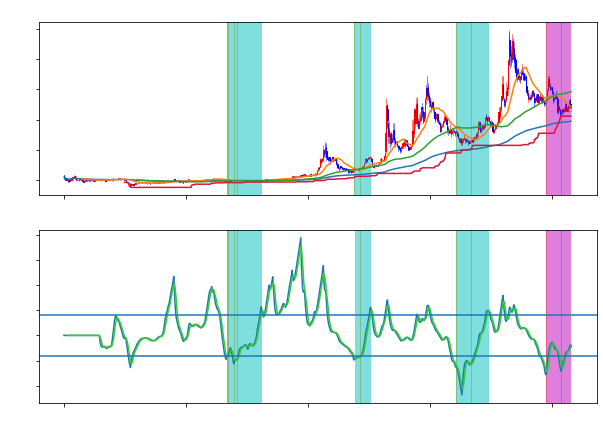

MXC (1.0977076952073377, 1.1350796575161233, 0.9670754716981133, 1.02447870561679, 0.9670754716981133, 0.9650136471275514)
MA_LONG_SLOPE : 138 -0.44245847363189345
Minus Profits at 197 0.992
MA_LONG_SLOPE : 478 0.7931848079267075
MA_LONG_SLOPE : 624 1.7344424464049153
MA_LONG_SLOPE : 752 1.2334206302273203
Minus Profits at 970 0.859


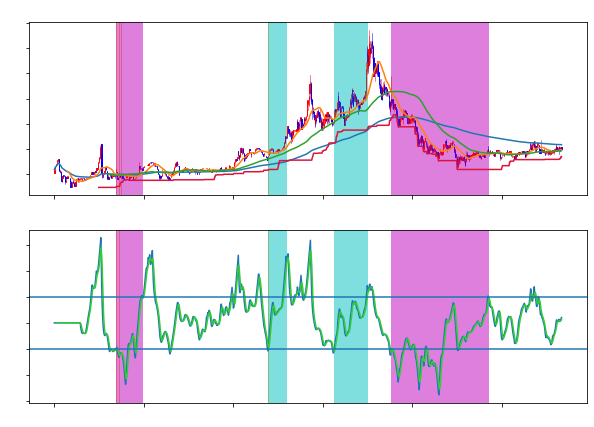

FAB (1.0225959371431617, 1.1998345484477375, 0.8522807902690627, 1.0108569399859189, 0.8593954575818302, 0.9878479366231598)
MA_LONG_SLOPE : 183 0.06282005354368399
Minus Profits at 308 0.991
MA_LONG_SLOPE : 393 0.057440740363470626
MA_LONG_SLOPE : 722 0.6656709509466188
Minus Profits at 799 0.994
MA_LONG_SLOPE : 881 0.0779128495831797
MA_LONG_SLOPE : 1002 0.24406987887191803


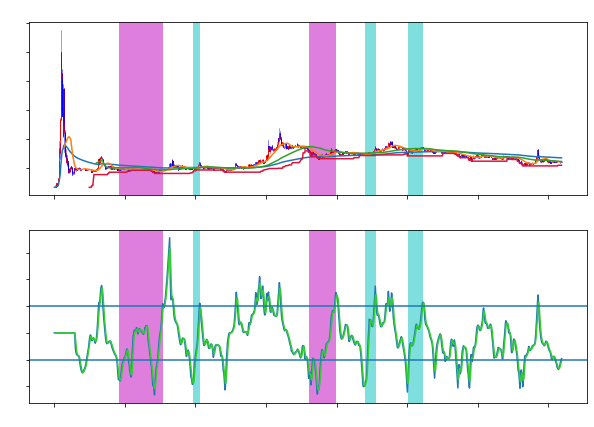

ANKR (1.116751130394154, 1.1342079873056197, 0.9846087691967894, 1.0226504524056281, 0.9909397733040095, 0.9871009946772413)
MA_LONG_SLOPE : 361 0.9102086506001127
MA_LONG_SLOPE : 520 0.47461979198680754
MA_LONG_SLOPE : 658 1.4915638323783427


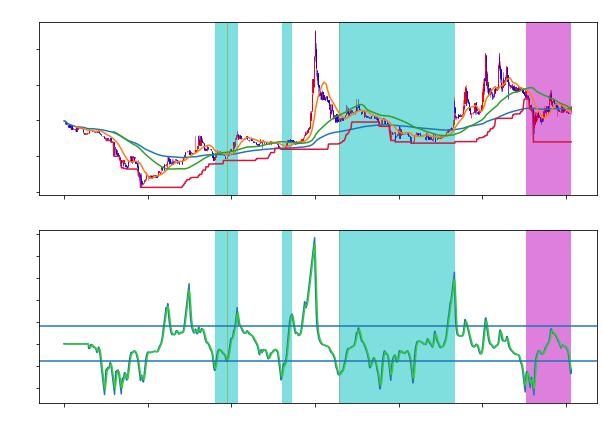

WET (1.0545875236601507, 1.1249888990293437, 0.9374203821656052, 1.0146561642551435, 0.9374203821656052, 0.9616167927506148)


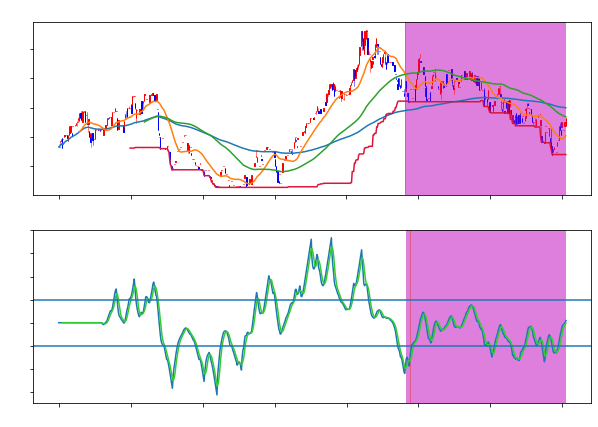

ENJ (0.9671254355400697, 1.0, 0.9671254355400697, 0.9671254355400697, 0.9671254355400697, 1.0)
MA_LONG_SLOPE : 223 0.45533519789820587
MA_LONG_SLOPE : 652 0.7630993748460277
Minus Profits at 943 0.966
MA_LONG_SLOPE : 981 -0.0657138014116747
MA_LONG_SLOPE : 1134 0.8685764330311011


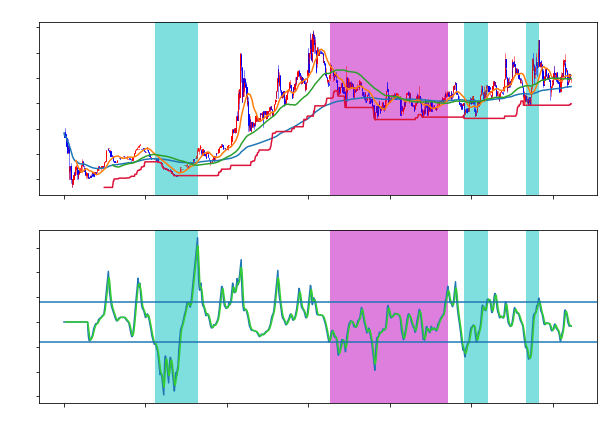

MIX (1.0267401719392344, 1.0632621487343408, 0.9656510138740662, 1.0069653062623363, 0.9656510138740662, 0.9788599389198781)
MA_LONG_SLOPE : 288 0.5287008504869083
MA_LONG_SLOPE : 452 1.2886129257569638


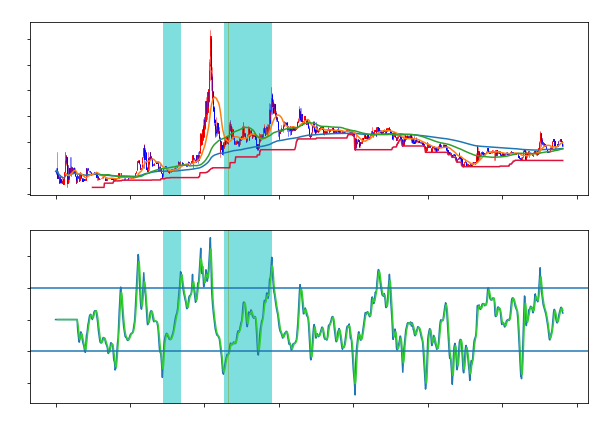

CON (1.1449981633344386, 1.1449981633344386, 1.0, 1.07156845281244, 1.0, 0.9807279435914436)
MA_LONG_SLOPE : 626 0.5248955722639682
MA_LONG_SLOPE : 850 0.24327485380094893


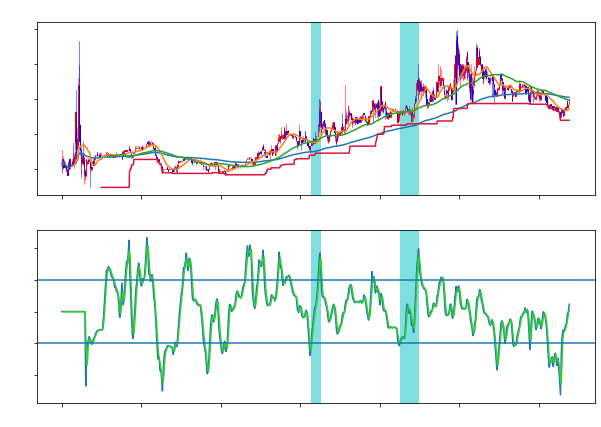

COS (1.0493834438506606, 1.0493834438506606, 1.0, 1.02439474909911, 1.0, 0.9951327433628319)
MA_LONG_SLOPE : 265 0.775668544298396
MA_LONG_SLOPE : 400 -0.18587309858787995
MA_LONG_SLOPE : 788 -0.19975681778710877
MA_LONG_SLOPE : 1188 -0.0413327046988642
Minus Profits at 1250 0.999


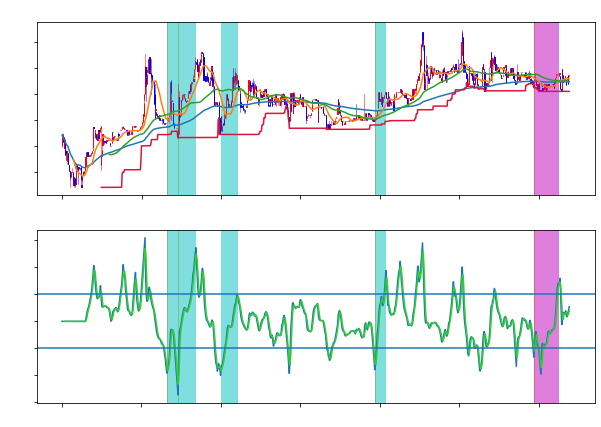

EGG (1.1014656756468106, 1.1025195102863836, 0.9990441578314572, 1.0246758632493678, 0.9990441578314572, 0.9875974412946503)
MA_LONG_SLOPE : 225 0.5898236156427415


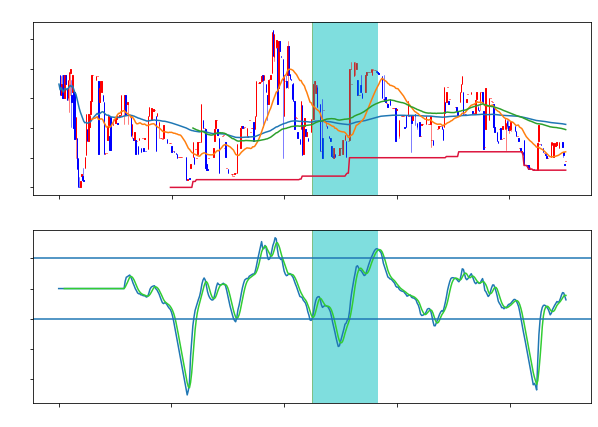

INS (1.0262246553122467, 1.0262246553122467, 1.0, 1.0262246553122467, 1.0, 0.9732360097323601)
MA_LONG_SLOPE : 148 0.18161046328398217
Minus Profits at 273 0.985
MA_LONG_SLOPE : 563 0.6047163192410443
MA_LONG_SLOPE : 727 0.9002812045082424
MA_LONG_SLOPE : 1035 1.8019693695314971
MA_LONG_SLOPE : 1211 1.3267074872810618


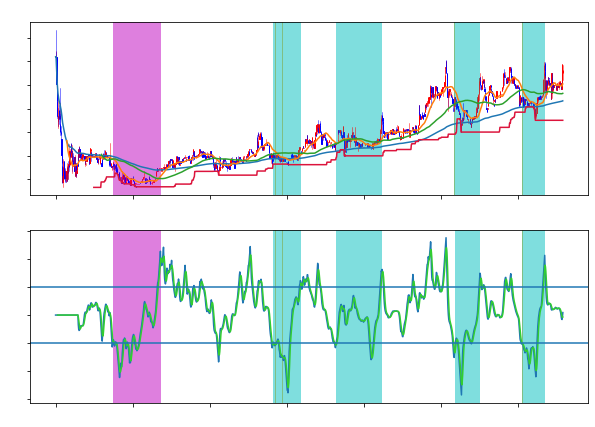

HYC (1.0521551061561456, 1.0678876109846418, 0.9852676399026765, 1.0103429857344242, 0.9852676399026765, 0.9700702799642344)
MA_LONG_SLOPE : 127 nan
MA_LONG_SLOPE : 381 0.639839243078095
MA_LONG_SLOPE : 640 0.4006935484667529


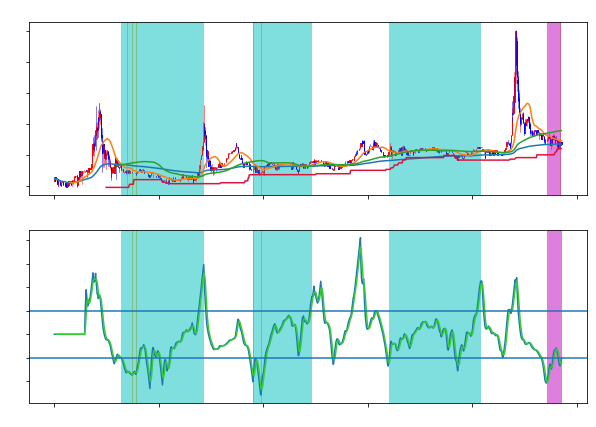

LBA (1.0452312156043972, 1.0596116595555076, 0.9864285714285715, 1.0114130073007122, 0.9864285714285715, 0.977909485498717)


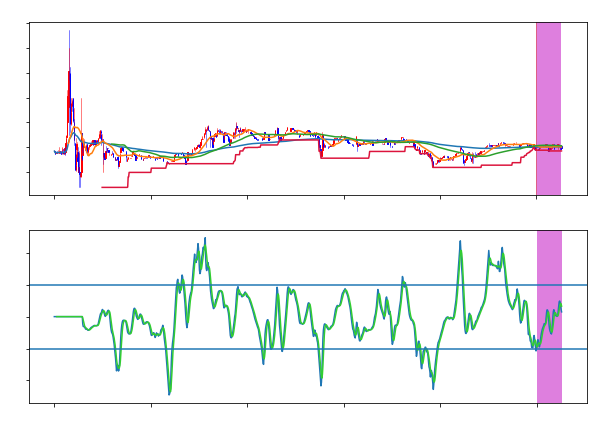

BZNT (0.9934615384615385, 1.0, 0.9934615384615385, 0.9934615384615385, 0.9934615384615385, 1.0)
MA_LONG_SLOPE : 432 0.9998877791493777
Minus Profits at 589 0.948
MA_LONG_SLOPE : 997 0.3797647102832135
Minus Profits at 1174 0.997


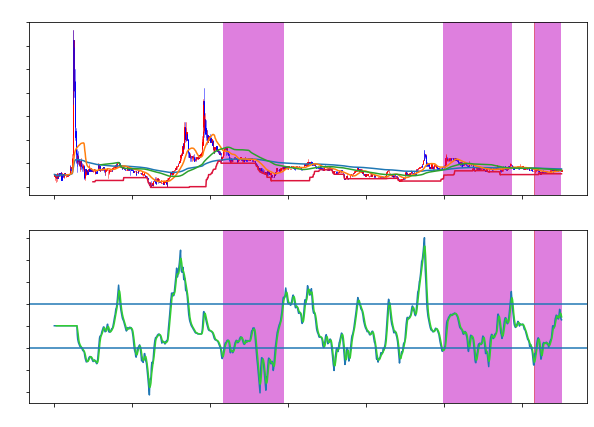

ARPA (0.9439440724071111, 1.0, 0.9439440724071111, 0.9812475777543197, 0.9475458953931416, 1.0)
MA_LONG_SLOPE : 265 2.1404612159326426
Minus Profits at 319 0.998
MA_LONG_SLOPE : 452 -0.5711448432402453
MA_LONG_SLOPE : 623 0.09357513280023168


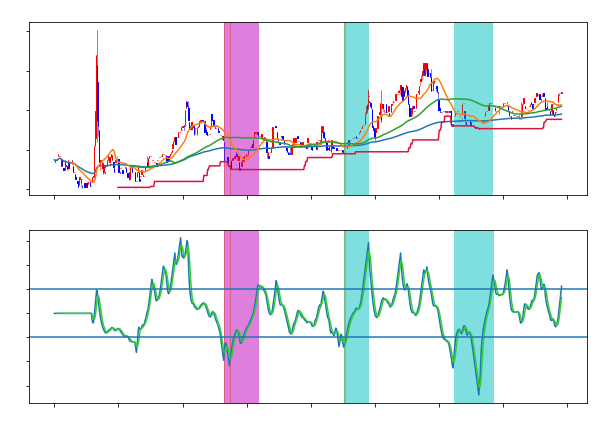

BOA (1.019794736543447, 1.0213547290947151, 0.9984726241463132, 1.0066035361448193, 0.9984726241463132, 0.9947826846788637)
MA_LONG_SLOPE : 227 1.7482408715824223
MA_LONG_SLOPE : 671 0.5455227227787575
MA_LONG_SLOPE : 1219 0.8605863600630974


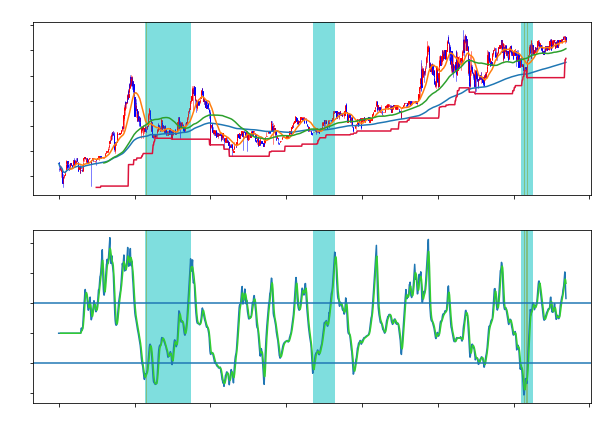

SXP (1.0718089288355577, 1.0718089288355577, 1.0, 1.023447932913342, 1.0, 0.988728833559609)
MA_LONG_SLOPE : 188 0.3348271809467564
MA_LONG_SLOPE : 349 2.3427424493436564


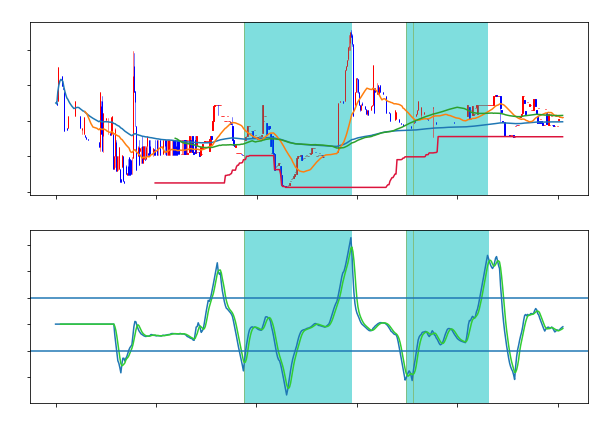

COSM (1.1074419493403196, 1.1074419493403196, 1.0, 1.0531265009400732, 1.0, 0.9687990198474377)
MA_LONG_SLOPE : 248 0.23913733351347213
MA_LONG_SLOPE : 806 -0.0690532222742011
MA_LONG_SLOPE : 907 0.35462664182398274
MA_LONG_SLOPE : 981 0.11728286449503428


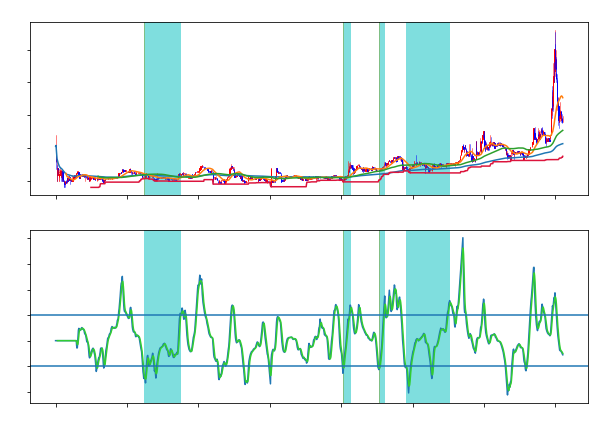

EM (1.0344521718215465, 1.0344521718215465, 1.0, 1.0085560434125158, 1.0, 0.9917738033236196)
MA_LONG_SLOPE : 180 0.43029110546132393
MA_LONG_SLOPE : 421 0.8324881448225684
MA_LONG_SLOPE : 600 0.45661591027928505
Minus Profits at 791 0.993
MA_LONG_SLOPE : 890 0.20841221759439926
MA_LONG_SLOPE : 1043 0.06417798092346194


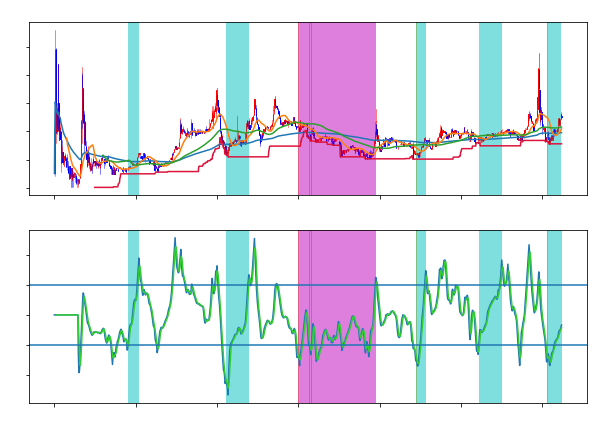

OGO (1.1066120737668959, 1.1143973621909407, 0.9930139026812315, 1.0171348806782532, 0.9930139026812315, 0.9871044152949668)
MA_LONG_SLOPE : 432 1.4827139619381975
Minus Profits at 523 0.999
MA_LONG_SLOPE : 618 0.736850099730865
MA_LONG_SLOPE : 752 0.446071318647552
Minus Profits at 1103 0.992
MA_LONG_SLOPE : 1206 0.9393699559902615


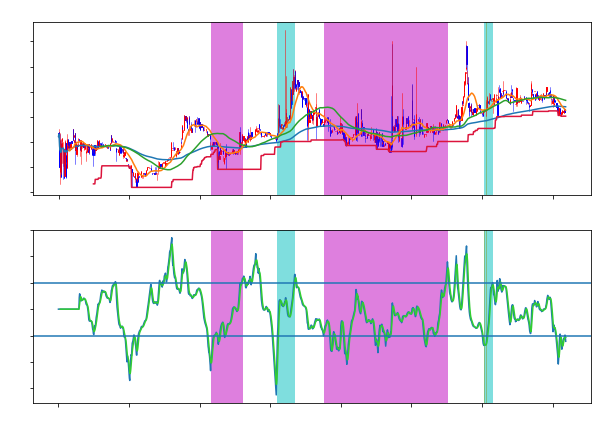

TRUE (1.0405903829051468, 1.0510033495609459, 0.9900923563562866, 1.0102432547325104, 0.9915745045265476, 0.9964891041162227)


In [ ]:
if __name__=="__main__":

    TopCoin = ['MXC', 'FAB', 'ANKR', 'WET', 'ENJ', 'MIX', 'CON', 'COS', 'EGG', 'INS', 'HYC', 'LBA', 'BZNT', 'ARPA', 'BOA', 'SXP', 'COSM', 'EM', 'OGO', 'TRUE']
    # TopCoin = ['ENJ']
    Date = str(datetime.now()).split()[0]

    # ohlcv_list = os.listdir(current_path + 'ohlcv/')
    # ohlcv_list = ['2019-10-05 LAMB ohlcv.xlsx']

    # for file in ohlcv_list:
    #     Coin = file.split()[1].split('.')[0]
    #     Date = file.split()[0]
    Date = str(datetime.now()).split()[0]
    # excel_list = os.listdir(current_path + 'BestSet/Test_ohlc/')
    total_df = pd.DataFrame(
        columns=['long_signal_value', 'short_signal_value', 'long_period', 'short_period', 'total_profit_avg',
                 'plus_profit_avg', 'minus_profit_avg', 'avg_profit_avg',
                 'min_profit_avg', 'exit_fluc_mean'])
    

    # for long_signal_value in np.arange(-1.5, -4, -0.5):
    #   for short_signal_value in np.arange(1.5, 4, 0.5):
    #     for long_period in np.arange(30, 100, 10):
    #       for short_period in np.arange(60, 500, 100):

    long_signal_value, short_signal_value = -2, 2
    long_period, short_period = 60, 60

    #       Make folder      #
    # try:
    #     os.mkdir("./Figure_pred/%s_%s_%s/" % (short, long, signal))
    #
    # except Exception as e:
    #     print(e)
    # long_signal_value, short_signal_value = -2.5, 2.5
    # long_period, short_period = 60, 60

    for Coin in TopCoin:

      if Coin.endswith('.xlsx'):
          if Coin.split('-')[1] not in ['07']: # or Coin.split('-')[2].split()[0] not in ['27, 29']:
              continue
      try:
          print(Coin,
                profitage(Coin, long_signal_value, short_signal_value, long_period, short_period, Date=Date,
                          get_fig=1, excel=0))
      except Exception as e:
          print('Error in profitage :', e)

        #     total_profit = 0
        #     plus_profit = 0
        #     minus_profit = 0
        #     avg_profit = 0
        #     min_profit = 0
        #     exit_fluc_mean = 0
        #     data_count = 0

        #     start = time.time()
        #     for Coin in ohlcv_list:

        #         #       지정 날짜만 확인    #
        #         if Coin.split()[0][-5:] == select_date:
        #             pass
        #         else:
        #           continue

        #         try:
        #             result = profitage(Coin, long_signal_value, short_signal_value, long_period, short_period, Date=Date, get_fig=0)
        #             if result[0] == 1.:  # 거래가 없는 코인을 데이터프레임에 저장할 필요가 없다.
        #                 continue
        #             print(Coin, result)
        #             data_count += 1

        #         except Exception as e:
        #             print('Error in profitage :', e)
        #             continue
        #         # quit()
                
        #         #     지정한 날짜에 해당하는 코인의 결과를 누적한다.    #
        #         total_profit += result[0]
        #         plus_profit += result[1]
        #         minus_profit += result[2]
        #         avg_profit += result[3]
        #         min_profit += result[4]
        #         exit_fluc_mean += result[5]

        #     total_profit_avg = total_profit / data_count
        #     plus_profit_avg = plus_profit / data_count
        #     minus_profit_avg = minus_profit / data_count
        #     avg_profit_avg = avg_profit / data_count
        #     min_profit_avg = min_profit / data_count
        #     exit_fluc_avg = exit_fluc_mean / data_count
        #     print(long_signal_value, short_signal_value, long_period, short_period, total_profit_avg, plus_profit_avg, minus_profit_avg, avg_profit_avg,
        #           min_profit_avg, exit_fluc_avg, '%.3f second' % (time.time() - start))

        #     result_df = pd.DataFrame(data=[
        #         [long_signal_value, short_signal_value, long_period, short_period, total_profit_avg, plus_profit_avg, minus_profit_avg, avg_profit_avg,
        #           min_profit_avg, exit_fluc_avg]],
        #                               columns=['long_signal_value', 'short_signal_value', 'long_period', 'short_period', 'total_profit_avg', 'plus_profit_avg',
        #                                       'minus_profit_avg', 'avg_profit_avg', 'min_profit_avg', 'exit_fluc_avg'])
        #     total_df = total_df.append(result_df)
        #     print()
                                
        # total_df.to_excel(gdrive_path + './BestSet/total_df %s.xlsx' % select_date)
        # break